# Single-Press Drift–Diffusion Model (DDM)

Minimal notebook for a single‑press, 5‑finger drift–diffusion process with damping and lateral inhibition; produces RT & accuracy across expectation conditions.

What you get:
- Single CONFIG block (edit parameters there)
- Core simulator + wrapper
- RT & Accuracy summary plot

Quick start:
1. Run cells top→bottom.
2. Adjust CONFIG if needed.
3. Re-run the results cell (Section 5) to update.

Sections:
1. Imports & Config
2. Helpers
3. Simulation Core
4. Model
5. RT & Accuracy Results
6. Summary


In [9]:
# --- 1. IMPORTS & CONFIG --------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from numba import jit

SEED = 42
np.random.seed(SEED)

# Figure style helper
def set_figure_style(width_key="1col"):
    widths_cm = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    if width_key not in widths_cm:
        raise ValueError("width_key must be one of '1col','1.5col','2col'")
    w_in = widths_cm[width_key] * 0.393701
    golden = (5**0.5 - 1) / 2
    rcParams.update({
        "figure.figsize": (w_in, w_in * golden),
        "font.size": 10,
        "axes.titlesize": 12,
        "axes.labelsize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 8,
        "axes.linewidth": 0.75,
        "xtick.major.width": 0.75,
        "ytick.major.width": 0.75,
        "text.usetex": False,
        "axes.formatter.use_mathtext": True,
    })

set_figure_style("1col")
sns.set_palette("colorblind")

# Finger color mapping (only 1st + 5th highlighted)
FINGER_COLORS = {1: sns.color_palette('colorblind')[0], 2: 'black', 3: 'black', 4: 'black', 5: sns.color_palette('colorblind')[5]}
FINGER_ALPHA = {1: 1.0, 2: 0.5, 3: 0.5, 4: 0.5, 5: 1.0}

# --- CONFIG (EDIT HERE) ---------------------------------------------------
SEQ = '1'
SPECIFIC_SEQ = '1'    # Learned / expected sequence
RAND_SEQ = '5'        # Random / incongruent sequence
SEQ_LEN = len(SEQ)

# Drift coefficients
VISUAL_DRIFT_COEF = 1.0
MEMORY_DRIFT_COEF = 0.6

# Core dynamical parameters
DIFFUSION = 3
THRESHOLD = 215
ALPHA = 0.9985
BETA = 0.01

# Delays (arbitrary time units)
VISUAL_DELAY = 90
MOTOR_DELAY = 50

# Simulation control
DT = 1
MAX_TIME = 10_000
N_SIMS = 1000

# --- DERIVED --------------------------------------------------------------
SQRT_DT = np.sqrt(DT)


### 2. Helpers
Drift builders, planning weights, evaluation utilities.

In [10]:
# --- 2. HELPERS -----------------------------------

def calc_visual_drifts(seq: str) -> np.ndarray:
    fingers = np.array([int(c) for c in seq]) - 1
    out = np.zeros((5, len(seq)))
    out[fingers, np.arange(len(seq))] = VISUAL_DRIFT_COEF
    return out

def calc_memory_drifts(seq: str) -> np.ndarray:
    fingers = np.array([int(c) for c in seq]) - 1
    out = np.zeros((5, len(seq)))
    out[fingers, np.arange(len(seq))] = MEMORY_DRIFT_COEF
    return out

# For single press correctness: max evidence finger must match target finger.
def check_sequence_match(evidence: np.ndarray, seq: str) -> bool:
    for i, ch in enumerate(seq):
        if np.argmax(evidence[:, i]) + 1 != int(ch):
            return False
    return True

def ipis_from_press_times(times):
    return [times[0]] + [times[i] - times[i-1] for i in range(1, len(times))]

### 3. Simulation Core
Single-press drift–diffusion with damping + lateral inhibition.

In [11]:
# --- 3. Simulation Core ---------------------------------------------------
@jit(nopython=True)
def simulate_single_press(visual_drifts, memory_drifts, diffusion, threshold, dt, max_time,
                          seq_length, window_size, visual_delay, motor_delay, alpha, beta):
    """Simulate a single-press sequence using a 5-unit DDM with damping and lateral
    inhibition.

    Returns press times (one per sequence
    position) and the evidence matrix (5 x seq_length).
    """
    # Evidence accumulator for each finger x sequence position
    evidence = np.zeros((5, seq_length))

    # Continuous time variable (arbitrary units)
    time = 0.0

    # Queues used to implement visual and motor delays. visual_delay_queue holds
    # elapsed time since items were revealed; motor_delay_queue holds elapsed
    # time since a press was planned but not yet executed.
    visual_delay_queue = np.zeros(min(window_size, seq_length))
    motor_delay_queue = np.zeros(0)

    # Indices tracking planned vs executed presses
    current_planned = 0  
    current_exec = 0

    # How many upcoming items are currently visible (revealed by the visual delay)
    visible_window = 0

    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    t_index = 0
    press_times = np.full(seq_length, np.nan)

    # Linear operator implementing damping (alpha) along diagonal and lateral
    # inhibition (beta) off-diagonal. A @ evidence implements one discrete step
    # of the leakage+inhibition dynamics.
    A = np.eye(5) * alpha - np.full((5, 5), beta) + np.eye(5) * beta

    # Main time-stepping loop
    while time < max_time - dt:
        # advance time and per-queue timers
        time += dt
        visual_delay_queue += dt
        if motor_delay_queue.size > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        # Apply damping + lateral inhibition + diffusion noise to all unexecuted
        # evidence columns (from current_planned onward).
        evidence[:, current_planned:] = A @ evidence[:, current_planned:]
        evidence[:, current_planned:] += diffusion_term * random_terms[:, current_planned:, t_index]

        # Add visual drift for items that are currently visible (within visible_window)
        upper_v = min(current_planned + visible_window, seq_length)
        for press in range(current_planned, upper_v):
            evidence[:, press] += drifts_visual_dt[:, press]

        # Add memory-based drift for all future presses (model of expectation)
        for press in range(current_planned, seq_length):
            evidence[:, press] += drifts_memory_dt[:, press]

        # Prevent negative accumulators (clamp at zero)
        evidence[:, current_planned:] = np.maximum(0, evidence[:, current_planned:])

        # Check whether any finger for the next planned press has reached threshold.
        # If so, mark the press as planned (shrink visible window) and push a motor
        # delay timer. The actual press time is recorded only after the motor delay
        # elapses (below).
        if (evidence[:, current_planned: current_planned + 1] >= threshold).any():
            visible_window -= 1
            current_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0.0)

        # Execute planned press when its motor delay has elapsed: record time and
        # advance execution counter.
        if motor_delay_queue.size > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0.0)
            press_times[current_exec] = time
            current_exec += 1
            if current_exec == seq_length:
                # All presses executed: end simulation early
                break

        # Reveal additional visual items when their visual delay timers pass the
        # visual_delay threshold. We increase the visible window by the number of
        # passed timers and remove them from the queue.
        reveal_mask = (visual_delay_queue >= visual_delay)
        passed = int(np.sum(reveal_mask))
        if passed > 0:
            visible_window += passed
            visual_delay_queue = visual_delay_queue[~reveal_mask]

    return press_times, evidence

### 4. Model

In [12]:
# --- 4.1 Lightweight wrapper ---------------------------------------------
class SinglePressDDM:
    def __init__(self, visual_drifts, memory_drifts,
                 diffusion=DIFFUSION, threshold=THRESHOLD,
                 dt=DT, max_time=MAX_TIME, seq_length=SEQ_LEN,
                 window_size=1, visual_delay=VISUAL_DELAY, motor_delay=MOTOR_DELAY,
                 alpha=ALPHA, beta=BETA):
        self.visual_drifts = visual_drifts
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.seq_length = seq_length
        self.window_size = window_size
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.alpha = alpha
        self.beta = beta

    def simulate(self):
        press_times, evidence = simulate_single_press(
            self.visual_drifts, self.memory_drifts, self.diffusion, self.threshold,
            self.dt, self.max_time, self.seq_length, self.window_size,
            self.visual_delay, self.motor_delay, self.alpha, self.beta)
        return ipis_from_press_times(press_times), evidence

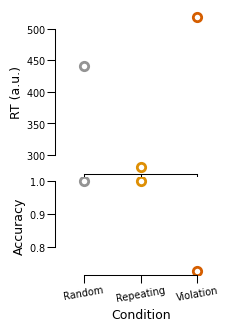

In [13]:
# --- 5. RT & Accuracy Results ---------------------------------------------
CONDITIONS = [
    ('Random', RAND_SEQ, None),              # random sequence, no memory expectation
    ('Repeating', SPECIFIC_SEQ, SPECIFIC_SEQ),  # expected / learned sequence
    ('Violation', RAND_SEQ, SPECIFIC_SEQ),      # visual violates memory expectation
]
rt_rows, acc_rows = [], []
for name, visual_seq, memory_seq in CONDITIONS:
    visual = calc_visual_drifts(visual_seq)
    memory = np.zeros((5, SEQ_LEN)) if memory_seq is None else calc_memory_drifts(memory_seq)
    model = SinglePressDDM(visual, memory)
    successes = 0
    for _ in range(N_SIMS):
        ipis, evidence = model.simulate()
        if check_sequence_match(evidence, visual_seq):
            successes += 1
            rt_rows.append((name, ipis[0]))
    acc_rows.append((name, successes / N_SIMS))
RT_df = pd.DataFrame(rt_rows, columns=['condition', 'RT'])
ACC_df = pd.DataFrame(acc_rows, columns=['condition', 'ACC'])
set_figure_style('1col')
rcParams['figure.figsize'] = (2.2, 3.2)
fig, (ax_rt, ax_acc) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[2.5,1.5], 'hspace':0.02}, sharex=True)
palette = {
    'Random': sns.color_palette('colorblind')[7],
    'Repeating': sns.color_palette('colorblind')[1],
    'Violation': sns.color_palette('colorblind')[3],
}
if not RT_df.empty:
    sns.pointplot(data=RT_df, x='condition', y='RT', hue='condition', linestyles='', palette=palette, ax=ax_rt, dodge=False, errorbar=None)
    leg = ax_rt.get_legend()
    if leg: leg.remove()
ax_rt.set_ylabel('RT (a.u.)', labelpad=2); ax_rt.set_xlabel('')
ax_rt.spines['bottom'].set_visible(False)
# ACC
sns.pointplot(data=ACC_df, x='condition', y='ACC', hue='condition', linestyles='', palette=palette, ax=ax_acc, dodge=False, errorbar=None)
leg = ax_acc.get_legend()
if leg: leg.remove()
ax_acc.set_ylabel('Accuracy', labelpad=2); ax_acc.set_xlabel('Condition')
# Small markers / thinner lines for compactness
for axis in (ax_rt, ax_acc):
    for artist in axis.findobj(match=plt.Line2D):
        if artist.get_marker() != 'None':
            artist.set_markerfacecolor('white')
            artist.set_markersize(6)
        artist.set_linewidth(0.9)
# Tighter ticks and layout
plt.xticks(rotation=10)
sns.despine(trim=True)
# plt.tight_layout(pad=0.25)
plt.subplots_adjust(top=0.95, bottom=0.12)
plt.show()

In [14]:
# --- 6. Summary ----------------------------------------------------------
print('Single-Press DDM Parameters:')
print(f'  Visual drift coef:  {VISUAL_DRIFT_COEF}')
print(f'  Memory drift coef:  {MEMORY_DRIFT_COEF}')
print(f'  Diffusion:          {DIFFUSION}')
print(f'  Threshold:          {THRESHOLD}')
print(f'  Alpha (damping):    {ALPHA}')
print(f'  Beta (inhibition):  {BETA}')
print(f'  Visual delay:       {VISUAL_DELAY}')
print(f'  Motor delay:        {MOTOR_DELAY}')
print(f'  N sims / condition: {N_SIMS}')

Single-Press DDM Parameters:
  Visual drift coef:  1.0
  Memory drift coef:  0.6
  Diffusion:          3
  Threshold:          215
  Alpha (damping):    0.9985
  Beta (inhibition):  0.01
  Visual delay:       90
  Motor delay:        50
  N sims / condition: 1000
